In [24]:
# !pip install ../..

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from generation.config import SIGNALS_TRAINING_CONFIG as CONFIG
from generation.dataset.signals_dataset import SignalsDataset
from generation.nets.signals_net import Generator, Discriminator
from generation.training.wgan_trainer import WganTrainer
from generation.utils import set_seed

set_seed()

2020-12-23 03:18:47.414 | INFO     | generation.utils:set_seed:14 - Set seed 42


In [2]:
config = CONFIG

dataset = SignalsDataset(signal_dim=config['x_dim'])
generator = Generator(config)
discriminator = Discriminator(config)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=config['g_lr'])
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=config['d_lr'])

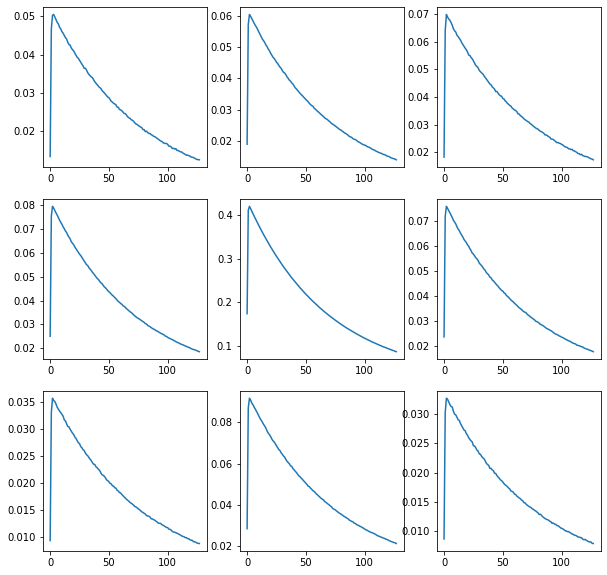

In [7]:
f, ax = plt.subplots(3, 3, figsize=(10, 10))
mean_signals = np.mean(dataset.signals, axis=1)
for i, signal in enumerate(mean_signals):
    ax[i // 3][i % 3].plot(mean_signals[i])
plt.show()

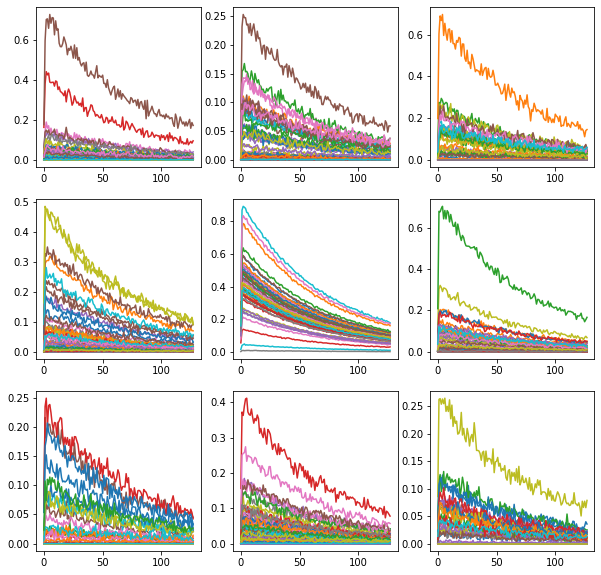

In [3]:
f, ax = plt.subplots(3, 3, figsize=(10, 10))


for _ in range(50):
    noises = dataset.signals[:, np.random.choice(range(len(dataset)))]
    for i in range(9):
        ax[i // 3][i % 3].plot(noises[i])
plt.show()

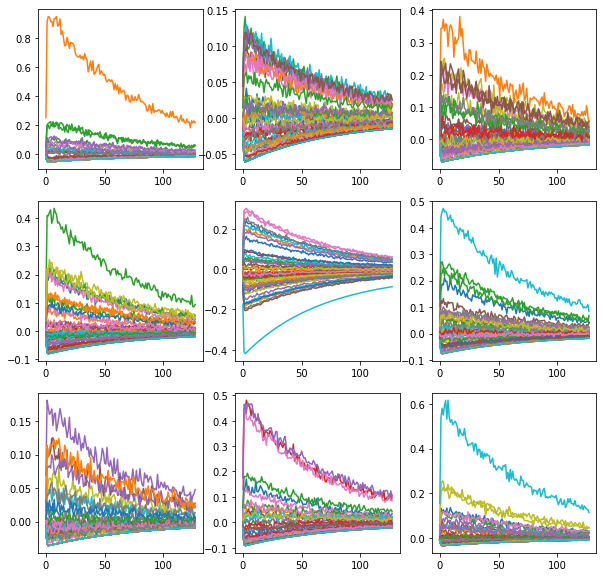

In [4]:
f, ax = plt.subplots(3, 3, figsize=(10, 10))


for _ in range(50):
    noises = dataset[np.random.choice(range(len(dataset)))]
    for i in range(9):
        ax[i // 3][i % 3].plot(noises[i])
plt.show()

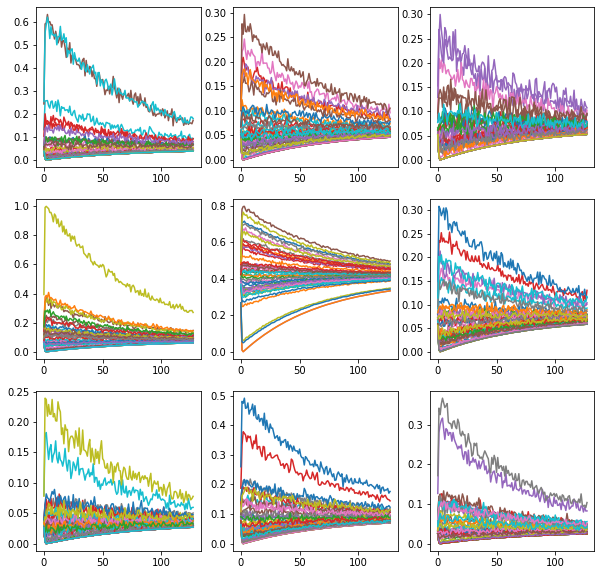

In [22]:
f, ax = plt.subplots(3, 3, figsize=(10, 10))


for _ in range(50):
    noises = dataset[np.random.choice(range(len(dataset)))]
    for i in range(9):
        ax[i // 3][i % 3].plot(noises[i])
plt.show()

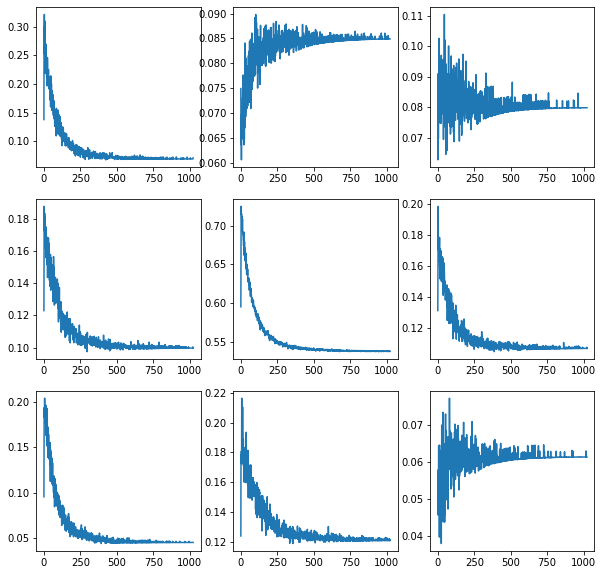

In [14]:
f, ax = plt.subplots(3, 3, figsize=(10, 10))

noises = dataset[40]

for i in range(9):
    ax[i // 3][i % 3].plot(noises[i])

In [ ]:
trainer = WganTrainer(generator, discriminator, g_optimizer, d_optimizer, config)
trainer.run_train(dataset)

wandb: Currently logged in as: whitera2bit (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.10.2
wandb: Run data is saved locally in wandb/run-20201018_142859-6ag8f46n
wandb: Syncing run stoic-pond-274


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 5/5000 [00:52<14:38:15, 10.55s/it]